# Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

# Image Pipeline

Import the python file containing object tracking pipeline. This file contains all of the classes and helper functions. All parameter choices are made in this document.

In [1]:
%load_ext autoreload
%autoreload 2

import time

# Import project packages
from imganalyser import ImageAnalyser
from carsearch import GridSearch
from carclassifier import Classifier
from datahandler import TrainingData
from utilityfun import *
from searchfilter import SearchFilter

In [2]:
%matplotlib inline

## The Car Classifier

The first step in the pipeline is to train a car classifier that is then used to identify cars in the subsequent sliding window search.

The feature set for the classifier consists of a histogram of oriented gradients (HOG), which essentially describes the shape of an image in a reduced feature space, by extracting the dominant gradient direction in so-called pixel cells which subdivide the image. In addition to the gradients, eac cell's color histogram is also recorded and used as a training feature.

### Histogram of Oriented Gradients (HOG)

The HOG is extracted from the lightness channel within the ImageFrame object which is in the HLS colour space. This ImageFrame object contains all of the information related to the current image or video frame of interest, including the HOG features and cell color histograms.

To improve the performance of the sliding window search, the HOG features are extracted once and then used for all queries. The size of the cell is already defined above.

In [3]:
cell_size = 8 #px
hog_params = {'orientations': 9,
              'pix_per_cell': cell_size,
              'cell_per_block': 2,
              'visualise': True}
histogram_bins = 32
colorspace = 'YCrCb'
spatial_size = (32, 32)

analyser = ImageAnalyser(hog_params, spatial_size=spatial_size, histogram_bins=histogram_bins, colorspace=colorspace)

When the image frame object is fed with an image, it automatically converts the image to the HLS colour space (from RGB) and computes the HOG features: 

In [4]:
preview = import_image('./test_images/image0120.png')
analyser(preview)

Visualise the result of the HOG feature extraction:

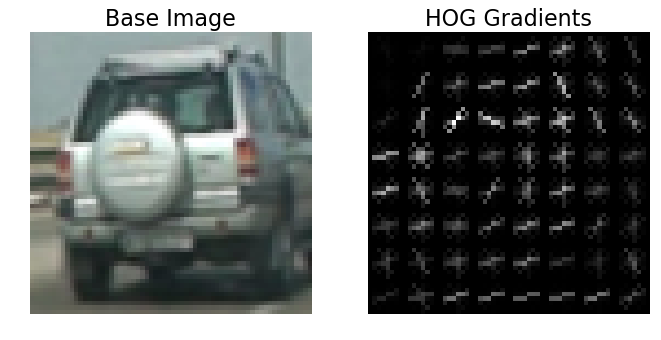

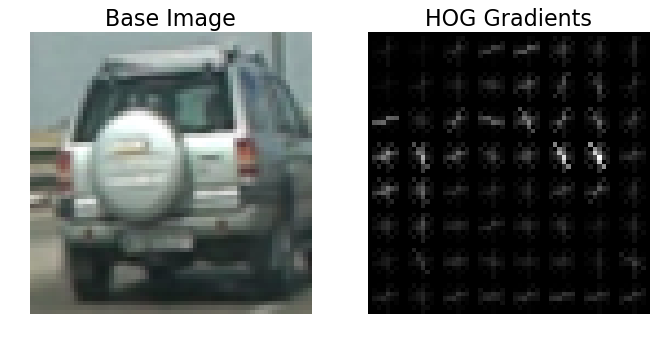

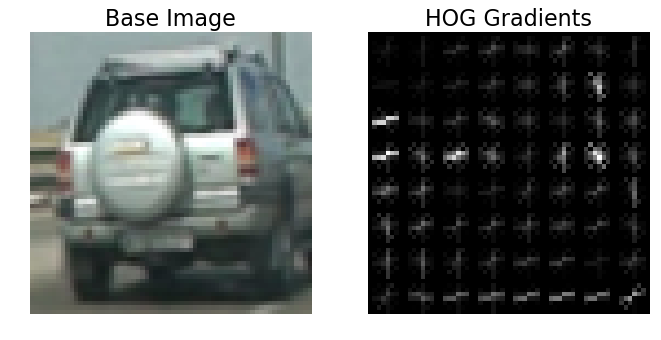

In [5]:
base_image = analyser.get_image()

for image in analyser.get_hog_visualisation():
    compare_images(base_image, image, ('Base Image', 'HOG Gradients'))

### Spatial Colour Bins and Histograms

For the colour features, the image is resized to a coarse representation and then each pixel channel is split into bins.

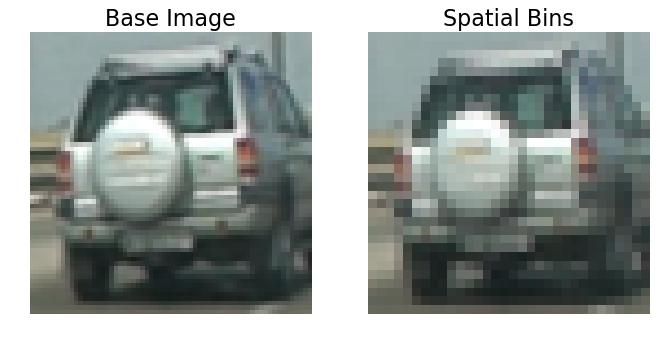

In [6]:
compare_images(base_image, analyser.get_spatial_visualisation(), ('Base Image', 'Spatial Bins'))

Finally, the histograms for each channel of the image are also recorded as features:

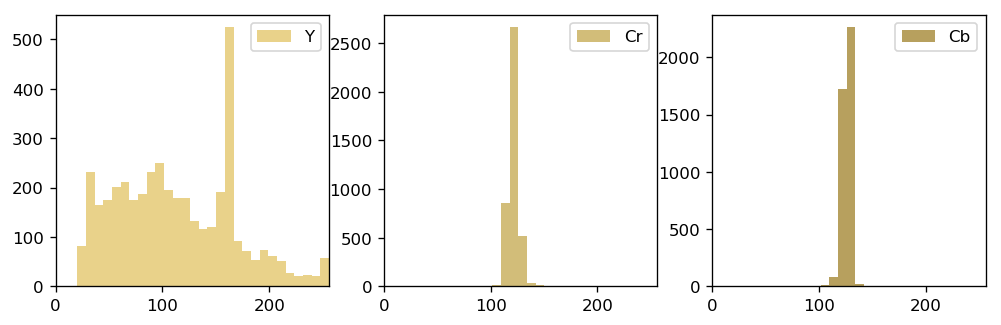

In [7]:
analyser.get_histogram_visualisation()

### Training the Classifier

Import the training data.

In [8]:
training_set = TrainingData('./training_data/')

Training data set imported.


A sample of the training images labeled as vehicles:

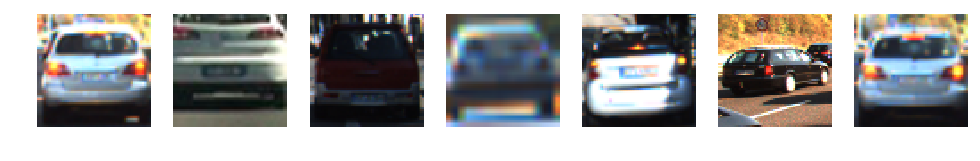

In [9]:
plt.subplots(1, 7, figsize=(12, 5), dpi=100)
for i, image in enumerate(training_set.get_random_training_images(label='vehicles', number=7)):
    plt.subplot(1, 7, i+1)
    plot_image(image)

A sample of the training images labeled as non-vehicles:

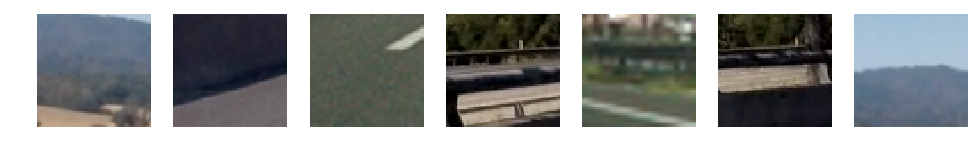

In [10]:
plt.subplots(1, 7, figsize=(12, 5), dpi=100)
for i, image in enumerate(training_set.get_random_training_images(label='non-vehicles', number=7)):
    plt.subplot(1, 7, i+1)
    plot_image(image)

Extract the desired training features from the data set. For this, the training set object makes use of an ImageFrame object to extract the features as seen above.

In [11]:
hog_params = {'orientations': 9,
              'pix_per_cell': cell_size,
              'cell_per_block': 2,
              'visualise': False}
analyser = ImageAnalyser(hog_params, spatial_size=(32, 32), histogram_bins=32, colorspace='YCrCb')

In [12]:
training_set.extract_features(analyser, hog_features=True)

Extracted feature vectors from images labelled as non-vehicles in 47.98790121078491 sec.
Extracted feature vectors from images labelled as vehicles in 48.25529599189758 sec.


Get training and test set:

In [13]:
(features_train, features_test, labels_train, labels_test) = training_set.get_data()

Set up a support vector machine classifier:

In [14]:
params = {'C': 1.0}
classifier = Classifier.svm_linear(params)

Normalising the features for fitting and inference:

In [15]:
classifier.fit_feature_scaler(features_train)

Fit the classifier to the training data:

In [16]:
classifier.train(features_train, labels_train, features_test, labels_test)

Classifier test accuracy =  0.9856 (took 0.39 seconds on 4440 entries)


The accuracy of the classifier looks promising, so it should be suitable to identify cars for object tracking in the video frames.

Discussion on what I found during training:

## Sliding Window Search

Set the sliding window parameters and the portions of the area of interest where the sliding window search should be conducted for each respective window size. The units for the search windows are in pixels.

By inspection of the video resolution, it is found that cars smaller than 48x48px (6x6 cells) would be so far away that they are no longer of interest (and also too badly resolved to identify easily). Similarly, cars that are larger than 192x192px (24x24 cells) are extremely close and will likely be identified easily even with partial coverage. Two additional search window sizes are used between these two extremes to cover the full spectrum adequately.

In [17]:
search_windows = {'far':      {'size': (8, 8),
                               'step_x': 2,
                               'step_y': 2,
                               'search_area': 'far'},
                  'near':     {'size': (16, 16),
                               'step_x': 4,
                               'step_y': 4,
                               'search_area': 'near'},
                  'nearest':  {'size': (24, 24),
                               'step_x': 12,
                               'step_y': 6,
                               'search_area': 'nearest'}}

Define the previously mentioned search areas as rectangles covering the area of interest.  The coordinates are given as fractions relative to the bounding box of the area of interest:

In [18]:
search_areas = {'nearest':  (( 2, 43), (158, 85)),
                'near':     (( 0, 48), (160, 72)),
                'far':      (( 0, 47), (160, 67)),
                'farthest': ((35, 49), (125, 61))}

Visualise the search areas in the image:

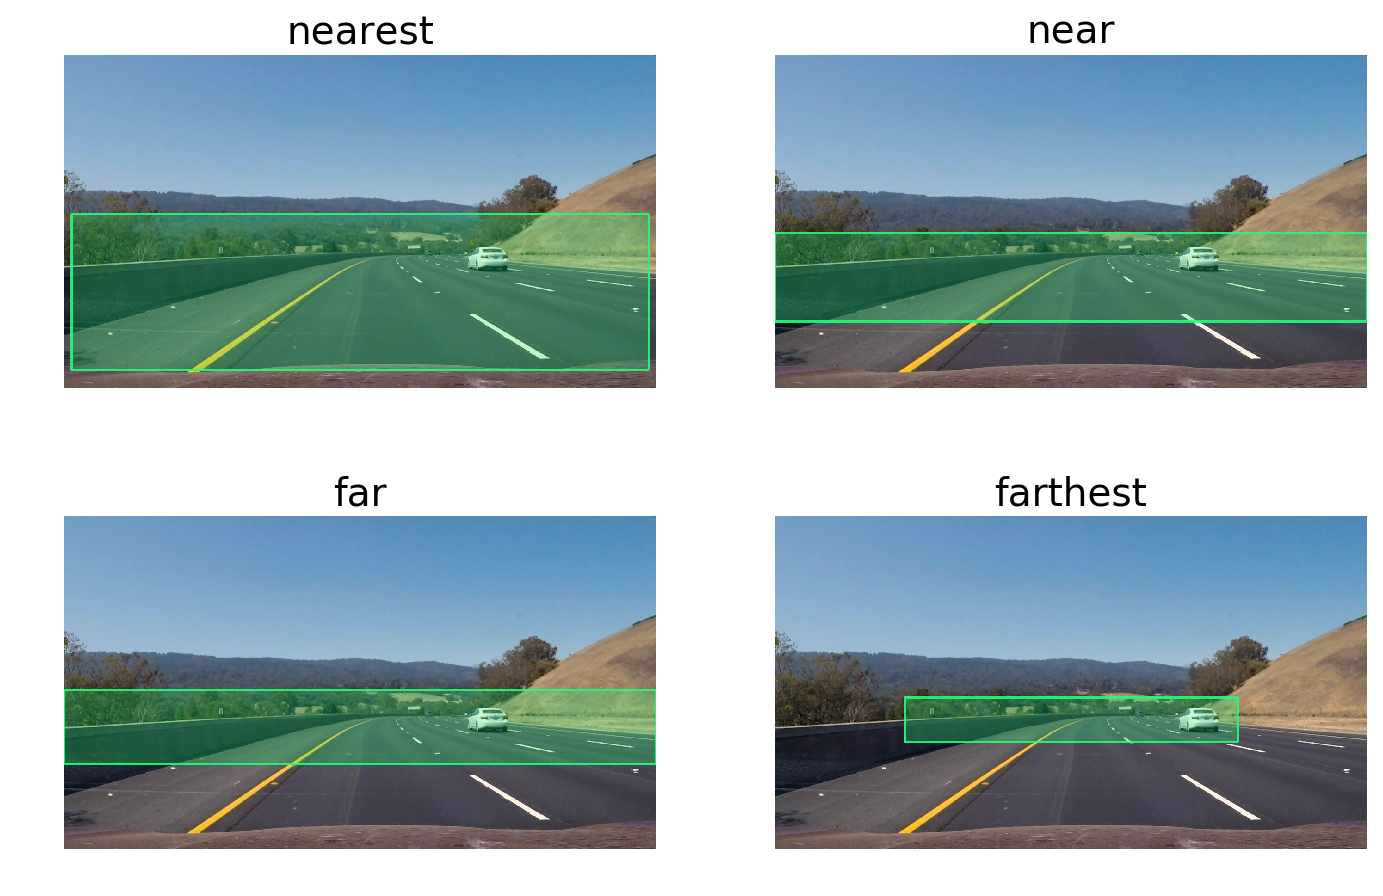

In [19]:
preview = import_image('./test_images/test3.jpg')

plt.subplots(2, 2, figsize=(12, 8), dpi=140)
i = 0

for name, area_of_interest in search_areas.items():
    area_of_interest = [(tup[0] * cell_size, tup[1] * cell_size) for tup in area_of_interest]
    if i == 4:
        export_image = searcher.get_area_of_interest(preview, area_of_interest)
        save_image(export_image)
    i += 1
    plt.subplot(2, 2, i)
    plot_image(quick_rectangle(preview, area_of_interest, filled=True), title=name)

Obtain a grid search object from these parameters, that can then be used to search the input images.

In [20]:
searcher = GridSearch(search_windows, search_areas, analyser)

Test the sliding search and image classifier on some test images:

Search took 0.88 seconds on this frame.
Search took 0.97 seconds on this frame.
Search took 1.0 seconds on this frame.
Search took 0.96 seconds on this frame.
Search took 1.01 seconds on this frame.
Search took 0.97 seconds on this frame.


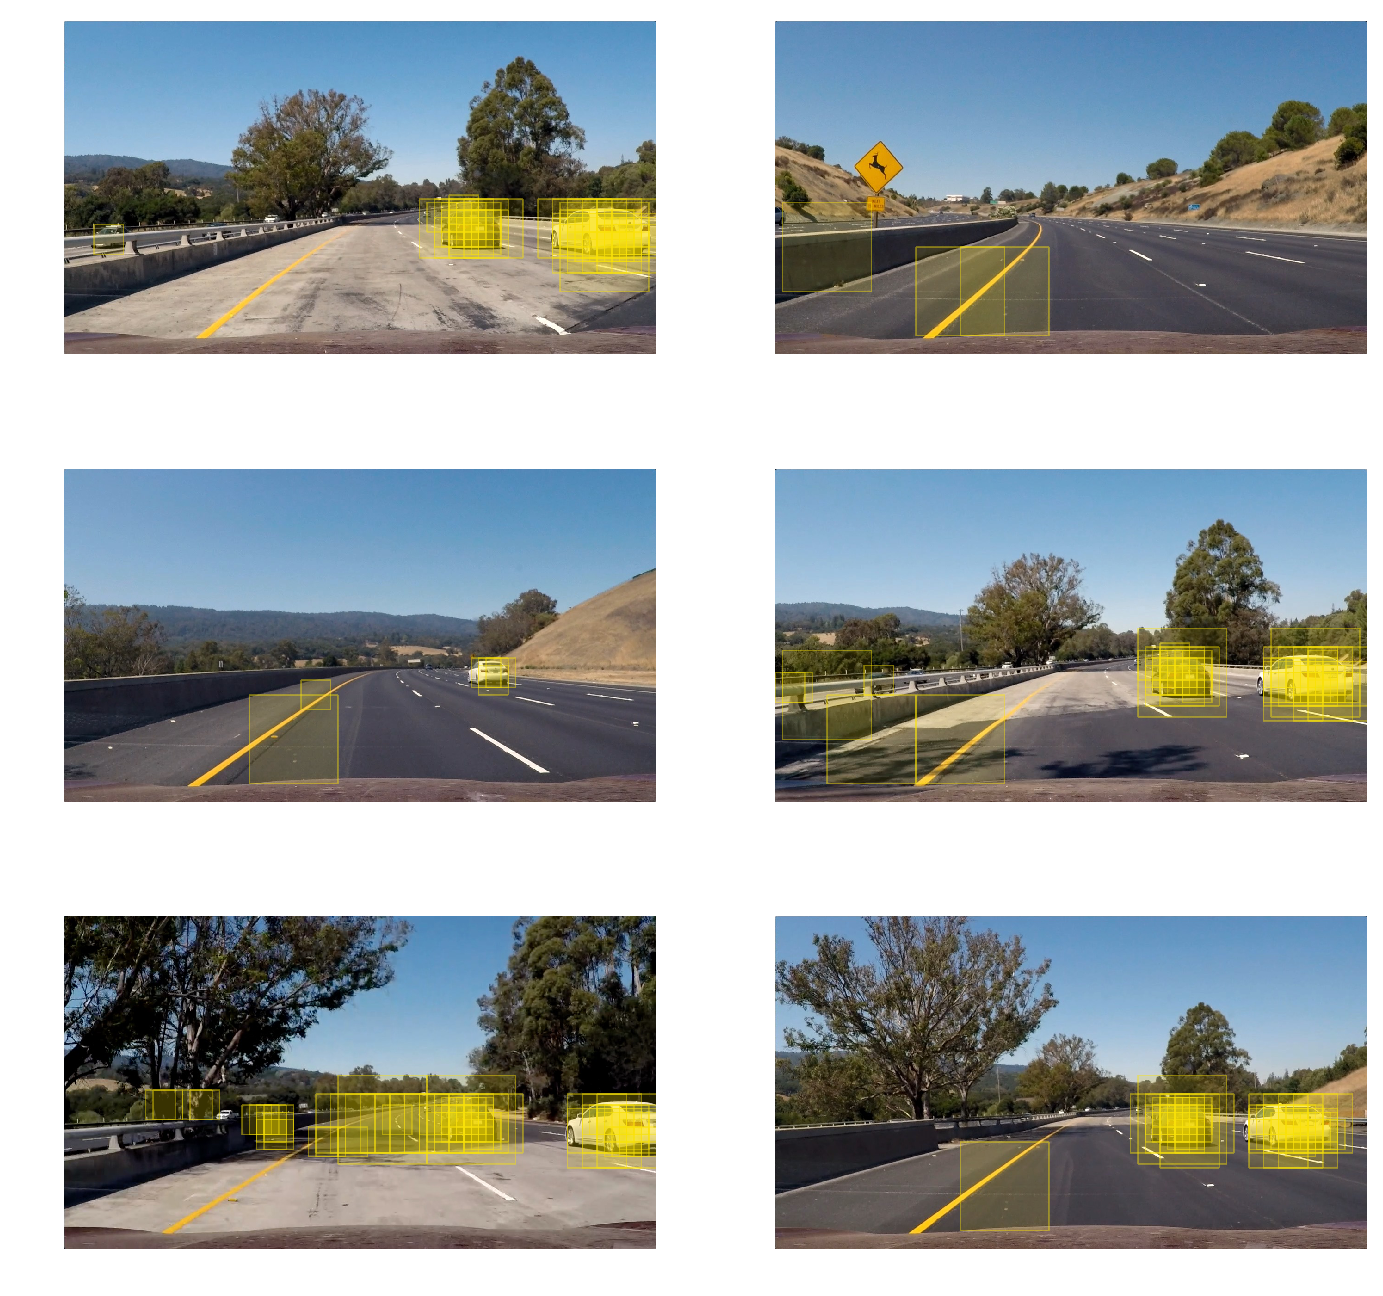

In [21]:
from glob import glob
test_image_files = glob('./test_images/test*.jpg')

subplot_rows = round(len(test_image_files)/2)
plt.subplots(subplot_rows, 2, figsize=(12, 12), dpi=140)
i = 0

for test_image_file in test_image_files:
    test_image = import_image(test_image_file)
    start = time.time()
    result = searcher.sliding_search(test_image, classifier)
    print('Search took', round(time.time() - start, 2), 'seconds on this frame.')
    highlighted_img = searcher.highlight_windows(test_image, result)
    output_file_name = 'BasicSlidingWindowSearch_' + test_image_file.split('/')[-1].replace('.jpg', '')
    save_image(highlighted_img, name=output_file_name)
    i += 1
    plt.subplot(subplot_rows, 2, i)
    plot_image(highlighted_img)

Discuss the results on the test images...

## Filtering False Positives and Duplicates

In order to filter out duplicates and false positives, all image regions which registered vehicle predictions by the classifier are combined into a scalar field. This field is visualised with the heatmaps below:

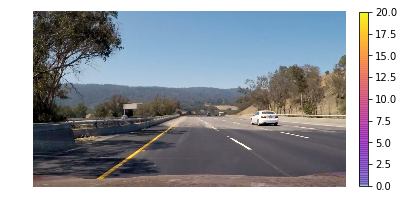

In [22]:
test_image = import_image('./test_images/Challenge_Image_1.png')
result = searcher.sliding_search(test_image, classifier)
search_processor = SearchFilter(test_image, search_windows)
search_processor.update(test_image, result, threshold=8)

search_processor.visualise_hitmap()
plt.show()

The hit intensity can be thresholded to get rid of all the duplicates and filter out some of the false positive outliers.

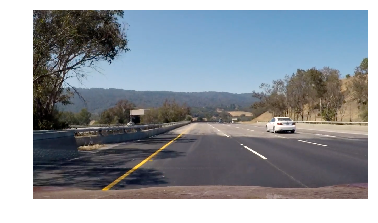

In [23]:
plot_image(search_processor.plot_detected_cars())

Run the grid searcher on the test images and write the output to the output file

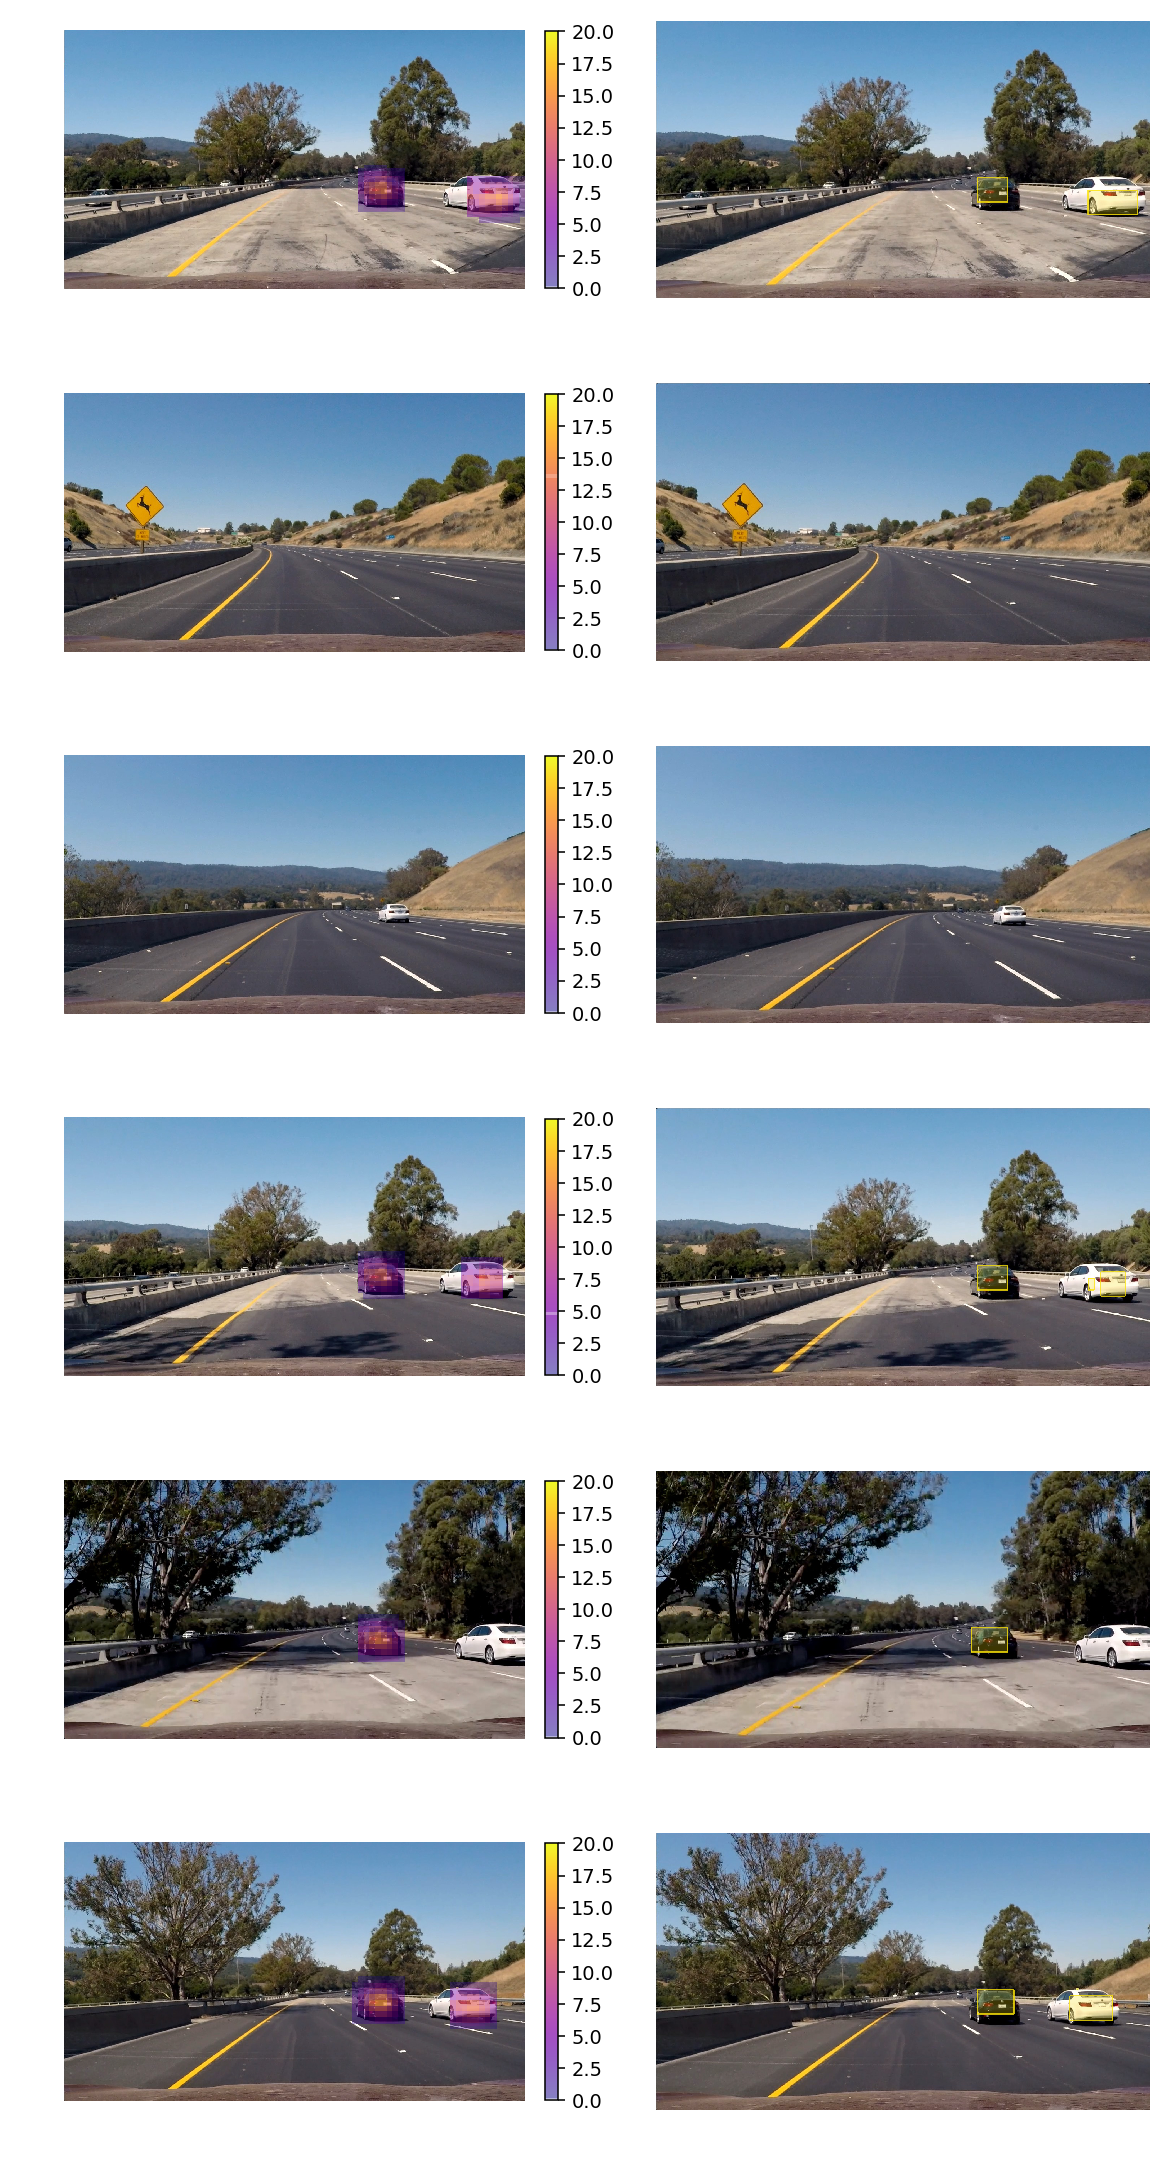

In [24]:
subplot_rows = round(len(test_image_files))
plt.subplots(subplot_rows, 2, figsize=(10, 20), dpi=140)
i = 0

for test_image_file in test_image_files:
    test_image = import_image(test_image_file)
    #Create a new object every loop to clear the hitmap from the previous image
    search_processor = SearchFilter(test_image, search_windows)
    #Run sliding window search
    result = searcher.sliding_search(test_image, classifier)
    #Filter search results
    search_processor.update(test_image, result, threshold=8)
    
    i += 1
    plt.subplot(subplot_rows, 2, (i*2 - 1))
    search_processor.visualise_hitmap()
    plt.subplot(subplot_rows, 2, (i*2))
    plot_image(search_processor.plot_detected_cars())
    

output_file_name = './output_images/TestImages_with_Heatmap_and_FilteredCars.jpg'
plt.savefig(output_file_name, bbox_inches='tight')

Discuss how well the cars are detected and the bounding boxes. Also explain that the performance on the video will be different because the hitmaps from the previous image will be reused.

Use previous hitmap as a multiplier instead?

# Processing Video

The following function takes in a video frame and a search_processor object and returns an annotated image, with a box drawn around the cars that were detected.

In [30]:
def find_cars(image, search_filter, searcher, classifier):
    """Function to identify and annotate cars in an input image."""
    #Run sliding window search
    sliding_search_result = searcher.sliding_search(image, classifier)
    #Filter search results
    search_filter.update(image, sliding_search_result, threshold=1)
    #Annotate image
    return search_filter.plot_detected_cars()

The pipeline developed up to this stage can now be tested on the short video clip to check how it works on time series images:

In [26]:
import imageio

video_name = 'tricky_video_2'
reader = imageio.get_reader(video_name + '.mp4')
fps = reader.get_meta_data()['fps']

video_output = video_name + '_annotated' + '.mp4'
writer = imageio.get_writer(video_output, fps=fps)

search_processor = SearchFilter(test_image, search_windows)

start = time.time()
i = 0

for image in reader:
    if i > 30 and i < 41:
        save_image(image, name=('sequence_' + str(i)))
    img_result = find_cars(image,
                           search_processor,
                           searcher,
                           classifier)
    writer.append_data(img_result.astype(np.dtype('uint8')))
    i += 1
print('Processing the video with', len(reader), 'frames took', round(time.time() - start, 2), 'seconds.')
writer.close()

Processing the video with 75 frames took 103.81 seconds.


0.0
19.0
18.81000000000001
18.629500000000018
18.505525000000027
18.482748750000038
18.271111312500047
18.260055746875057
18.249552959531318
18.192075311554763


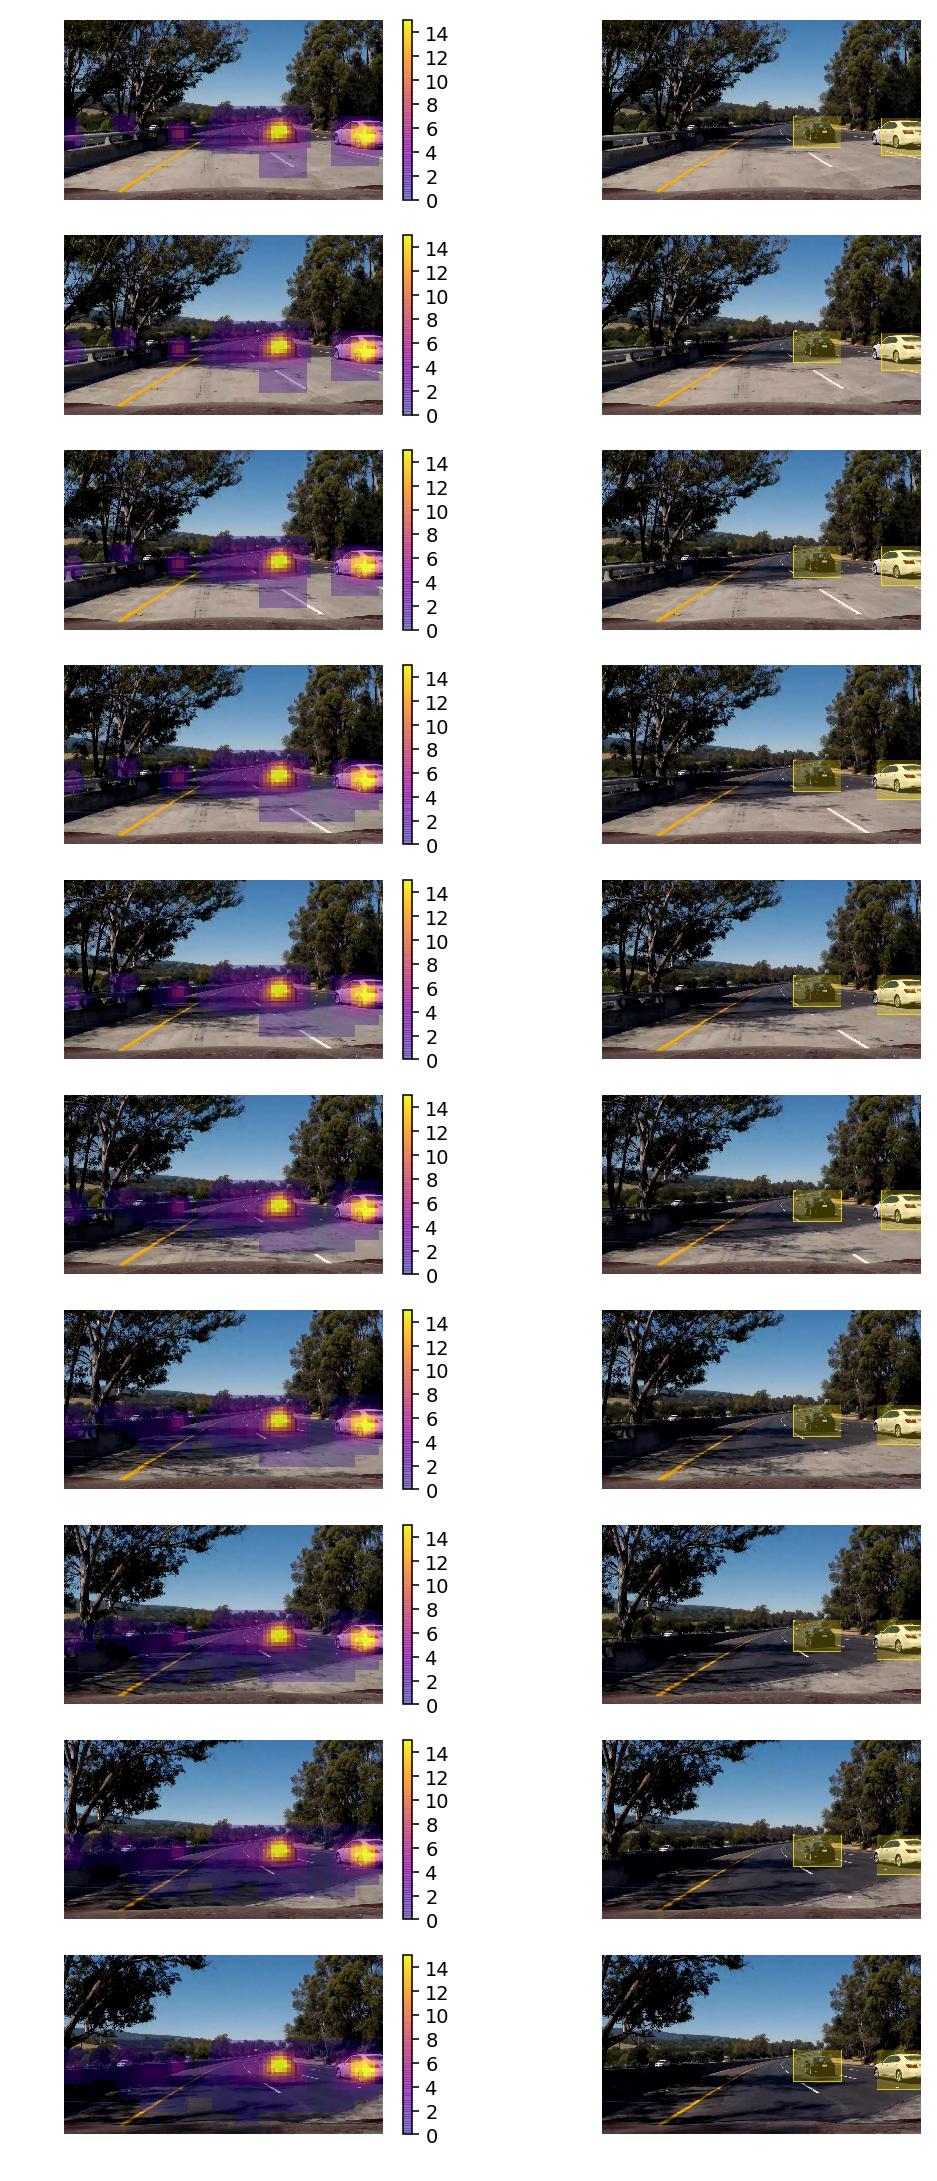

In [40]:
test_image_files = glob('./output_images/sequence*.jpg')

subplot_rows = round(len(test_image_files))
plt.subplots(subplot_rows, 2, figsize=(10, 20), dpi=140)
i = 0

search_processor = SearchFilter(test_image, search_windows)

for test_image_file in test_image_files:
    test_image = import_image(test_image_file)
    #Run sliding window search
    result = searcher.sliding_search(test_image, classifier)
    #Filter search results
    search_processor.update(test_image, result, threshold=3)
    
    i += 1
    plt.subplot(subplot_rows, 2, (i*2 - 1))
    search_processor.visualise_hitmap()
    plt.subplot(subplot_rows, 2, (i*2))
    plot_image(search_processor.plot_detected_cars())